In [ ]:
%pip install numpy pandas scikit-learn matplotlib imblearn nltk

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib.pylab import plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv("D:\Downloads\WELFake_Dataset.csv")
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [4]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


# Data Preprocessing

In [5]:
#drop unnecessary columns
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [6]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


<AxesSubplot:>

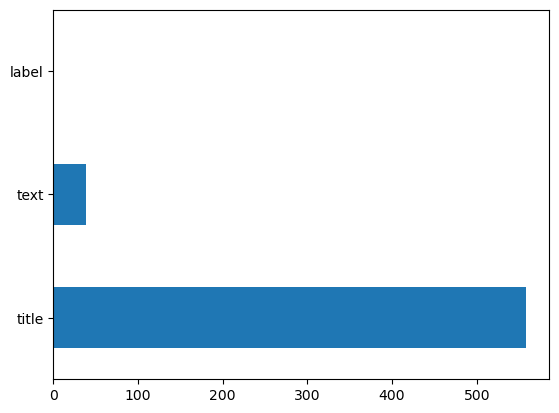

In [7]:
data.isnull().sum().plot(kind='barh')

In [8]:
data = data.fillna('')

In [9]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

Add new features to the dataset

In [12]:
data["news_appended"] = data["title"] + data["text"]
data["news_length"] = data["news_appended"].apply(lambda x: len(x) - x.count(" "))
data

,title,text,label,news_appended,news_length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668
...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....,4098
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...,3092
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...,2447
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,Trump tussle gives unpopular Mexican leader mu...,2868


Visualize the distribution of news article lengths

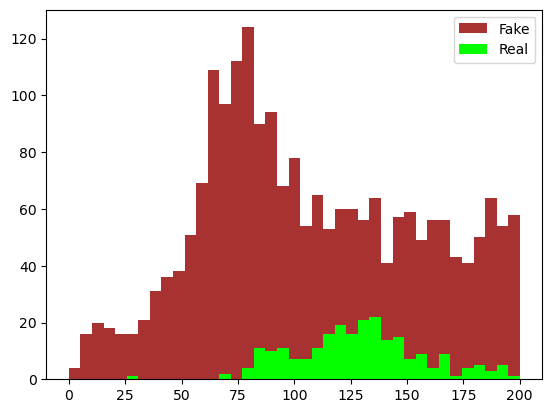

In [13]:
bins = np.linspace(0, 200, 40)

plt.hist(data[data["label"]== 1]["news_length"], bins, alpha=1, label="Fake", color="#a83232")
plt.hist(data[data["label"]== 0]["news_length"], bins, alpha=1, label="Real", color="#04ff00")
plt.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'Distribution of Articles')

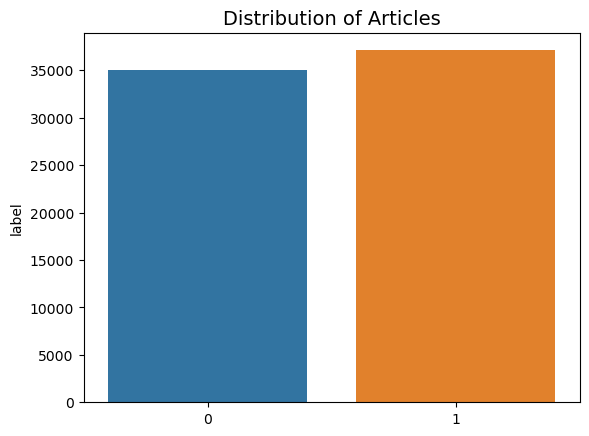

In [14]:
class_names = ['fake', 'real'] 
label_count = data.label.value_counts()
sns.barplot(x=label_count.index, y=label_count)
plt.title('Distribution of Articles',fontsize =14)

Apply undersampling on the dataset

In [15]:
X = data[data.columns[:-1]].values
y = data['label'].values
rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new DataFrame with the undersampled data
undersampled_data = pd.DataFrame(X_resampled, columns=data.columns[:-1])
undersampled_data['label'] = y_resampled

# Update the original data with the undersampled data
data = undersampled_data

# Print the class distribution after undersampling
unique_classes, class_counts = np.unique(data['label'], return_counts=True)
print("Class distribution after undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print("Class {}: {}".format(cls, count))

Class distribution after undersampling:
Class 0: 35028
Class 1: 35028


### Cleaning of Text

In [16]:
data.count()

title            70056
text             70056
label            70056
news_appended    70056
dtype: int64

In [17]:
# Preprocess the text data
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stopwords_list = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [18]:
data['news_appended'] = data['news_appended'].apply(preprocess_text)

In [19]:
#Tokenize preprocessed data
tokenized_text = data['news_appended'].apply(word_tokenize)

#Word Embedding
model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
embedded_text = []
for tokens in tokenized_text:
    embedded_tokens = []
    for token in tokens:
        try:
            embedding = model.wv.get_vector(token)
            embedded_tokens.append(embedding)
        except KeyError:
            pass
    embedded_text.append(np.mean(embedded_tokens, axis=0))


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScale

#split transformed data into training and testing
X_train, X_test, y_train, y_test = train_test_split(embedded_text, data['label'], test_size=0.2, random_state=42)

Scale the data

In [ ]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Model Training and Testing

### Decision Tree Classifier

Decision Tree:
Accuracy: 0.8649015129888666
Precision: 0.8548498685484986
Recall: 0.8798063229849046
F1 Score: 0.8671485718296021
ROC AUC Score: 0.8648673961133392


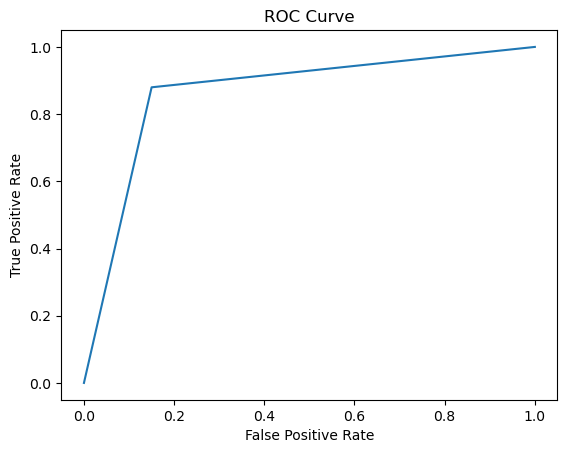

In [23]:
# Train the Decision Tree classifier
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=None, min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_features=None, random_state=32)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

# Evaluate the model
print("Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Precision:", precision_score(y_test, y_pred_dtc))
print("Recall:", recall_score(y_test, y_pred_dtc))
print("F1 Score:", f1_score(y_test, y_pred_dtc))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_dtc))
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Support Vector Machine Classifier

In [24]:
svm = SVC(kernel='linear', C=1, gamma='scale')

In [25]:
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear')

Decision Tree:
Accuracy: 0.9108621181844133
Precision: 0.9108896797153024
Recall: 0.9112788379379094
F1 Score: 0.9110842172705915
ROC AUC Score: 0.9108611643194555


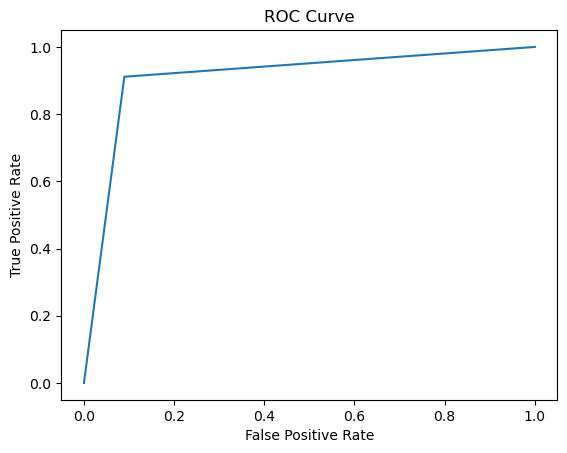

In [26]:
svm_preds = svm.predict(X_test)

# Evaluate the model
print("Decision Tree:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Precision:", precision_score(y_test, svm_preds))
print("Recall:", recall_score(y_test, svm_preds))
print("F1 Score:", f1_score(y_test, svm_preds))
print("ROC AUC Score:", roc_auc_score(y_test, svm_preds))
fpr, tpr, _ = roc_curve(y_test, svm_preds)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Naive Bayes Classifier

Decision Tree:
Accuracy: 0.7869683128746788
Precision: 0.7902228612508987
Recall: 0.7826829962973512
F1 Score: 0.7864348572655077
ROC AUC Score: 0.7869781218968872


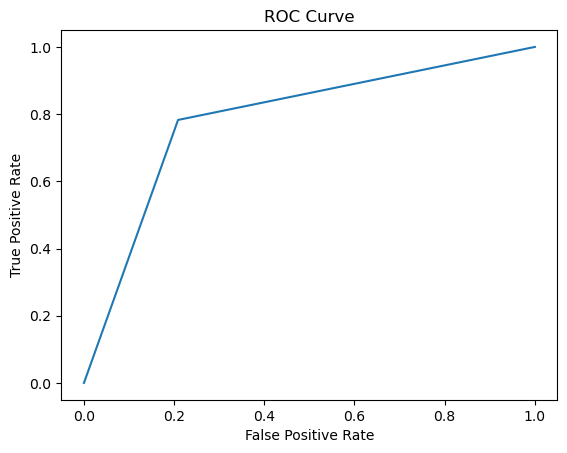

In [27]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_mnb = gnb.predict(X_test)


#Evaluate Model
print("Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("Precision:", precision_score(y_test, y_pred_mnb))
print("Recall:", recall_score(y_test, y_pred_mnb))
print("F1 Score:", f1_score(y_test, y_pred_mnb))
print("ROC AUC Score:", roc_auc_score(y_test,y_pred_mnb))
fpr, tpr, _ = roc_curve(y_test, y_pred_mnb)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()